In [189]:
import pandas as pd
import urllib.request
import numpy as np
import glob
import os
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
import time
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn import preprocessing
from sklearn import metrics
from sklearn import utils
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

In [20]:
# to make this notebook's output stable across runs
np.random.seed(42)

In [3]:
# This downloads a dictionary file
dictionary_filename = "./raw/tcga_dictionaries.txt"
if os.path.isfile(dictionary_filename):
    print("Skipping download, as file %s is present" %(dictionary_filename))
else:
    print('Downloading dictionary file...')
    url = 'https://w207-final-project.s3.amazonaws.com/raw/tcga_dictionaries.txt'  
    urllib.request.urlretrieve(url, dictionary_filename)  
print("done.")

# This loads the data dictionary to will convert
# the tumor_sample_barcode into a cancer_type
# and provide full names for the cancer types
tcga_dict = open("./raw/tcga_dictionaries.txt","r")
dict_name_index = 0 #Set dictionary index counter to 0
for line in tcga_dict:
    if line.startswith("#"): #If line starts with #, the next line will be a known dictionary
        dict_name_index += 1
    elif dict_name_index == 4:
        tissue_source_site = eval(line)            
    elif dict_name_index == 5:
        code_to_disease = eval(line)
    elif dict_name_index == 6:
        disease_to_code = eval(line)

Skipping download, as file ./raw/tcga_dictionaries.txt is present
done.


In [6]:
def getDataAndLabels(name, features, label_encoder):
    labels_string = features.cancer_type
   
    labels        = label_encoder.fit_transform(labels_string)

    # Get rid of the cancer type and patient_barcode columns 
    data = features[features.columns[3:]]

    return {'name': name, 'feature_size': data.shape[1],
            'data': data, 'labels': labels , 'label_encoder': label_encoder }

## Model Details ##

Based on a full matrix run of all classifiers on all datasets, we find that LogisticRegression gives the best results with the file **l1reg_c10**, which is a dataset obtained by doing L1 regularization with a **C** value of **10**. For this dataset, we determined a **C** value of **0.1** using GridSearchCV for the actual classification task. Using this value of the hyper-parameter, our results were:


**Accuracy:**  0.555012225	
**Precision:** 0.603711834	
**Recall:**    0.555012225	
**F1 Score:**  0.531877786	
**Run Time:**  97.03445305 seconds

We will analyze the results of this classifier in this section.

In [62]:
# get the data and labels from the dataset being analyzed
def get_data_labels(file_name, le=None):  
    data = pd.read_csv(file_name)
    data = data.drop(columns=["Unnamed: 0", "case_id"])
    if le is None:
        le = preprocessing.LabelEncoder()
        labels = le.fit_transform(data.cancer_type)
    else:
        labels = le.transform(data.cancer_type)
    data = data.drop(columns=["cancer_type"])
    return data, labels, le

In [176]:
def run_classifier(train_data, train_labels):
    # setup and run the LR classifier according to specification
    cfr = LogisticRegression(penalty='l2', tol=.01, max_iter=150, 
                             C=0.01, solver="lbfgs", 
                             multi_class="multinomial", random_state=42)
    cfr.fit(train_data, train_labels)
    predict = cfr.predict(test_data)
    return cfr, predict

In [122]:
def analyze_classifier(test_labels, predict_labels, encoder):
    print("\nClassification Report: \n")
    print(metrics.classification_report(test_labels, predict_labels))
    conf_matrix = metrics.confusion_matrix(test_labels, predict_labels)
    
    print("Confusion Matrix Analysis: \n")
    for i in range(conf_matrix.shape[0]):
        conf_matrix[i][i] = 0
        cases = sum(conf_matrix[i])
        m = np.argmax(conf_matrix[i])
        w = conf_matrix[i][m]
        print("Cancer: %s [%d cases], \tmisclassifed as %s [%d cases]"
          %(encoder.classes_[i], cases, encoder.classes_[m], w))

In [136]:
# load the training data and labels into memory
train_data, train_labels, encoder = get_data_labels("./data/features_l1reg_c10.train.csv")

In [137]:
encoder.classes_

array(['ACC', 'BLCA', 'BRCA', 'CESC', 'CHOL', 'COAD', 'DLBC', 'ESCA',
       'GBM', 'HNSC', 'KICH', 'KIRC', 'KIRP', 'LAML', 'LGG', 'LIHC',
       'LUAD', 'LUSC', 'MESO', 'OV', 'PAAD', 'PCPG', 'PRAD', 'READ',
       'SARC', 'SKCM', 'STAD', 'TGCT', 'THCA', 'THYM', 'UCEC', 'UCS',
       'UVM'], dtype=object)

(array([ 67., 322., 809., 231.,  24., 322.,  31., 155., 317., 418.,  51.,
        305., 222., 111., 404., 285., 462., 379.,  67., 330., 141., 142.,
        406., 120., 195., 367., 365., 110., 370., 101., 444., 106.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32.]),
 <a list of 32 Patch objects>)

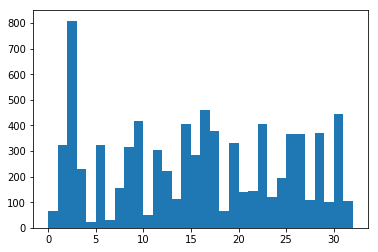

In [141]:
plt.hist(train_labels, bins=32)

In [40]:
train_data.head()

,JAKMIP3,PANX3,SPI1,NAALAD2,FAT3,MTERFD3,BTBD11,NOS1,SLC2A14,SLC2A3,...,MIR563,AC020629.1,GOLGA8Q,AC092850.1,RFPL4AL1,UBE2DNL,RP11-368I7.4,C11orf91,MIR4280,RP11-261N11.8
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:
train_data.shape

(8179, 14226)

In [63]:
# load the test data and labels into memory
test_data, test_labels, _ = get_data_labels("./data/features_l1reg_c10.test.csv", encoder)

In [179]:
# setup and run the LR classifier according to specification
lr_cfr, predict_labels = run_classifier(train_data, train_labels)

## Analysis of Local Results ##

We were not able to replicate the results of the full-matrix search, but we get an overall weighted average score of 0.52. More importantly, we see that some of the cancers such as **ACC** do very poorly.

In [180]:
analyze_classifier(test_labels, predict_labels, encoder)


Classification Report: 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.73      0.49      0.59        89
           2       0.21      0.95      0.34       211
           3       0.75      0.05      0.10        58
           4       0.00      0.00      0.00        12
           5       0.64      0.70      0.67        84
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00        29
           8       0.86      0.41      0.55        76
           9       0.39      0.44      0.41        89
          10       0.00      0.00      0.00        15
          11       0.78      0.62      0.70        64
          12       0.00      0.00      0.00        59
          13       0.00      0.00      0.00        30
          14       0.88      0.85      0.86       108
          15       0.88      0.18      0.30        78
          16       0.73      0.64      0.68       105
 

/Users/vijay/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


We can see the problem here. Since cancer BRCA is over represented in the training set, we are getting all cancers classified as BRCA. Let's try to fix this.

In [154]:
def split_data_labels(raw_data, encoder):
    labels = encoder.transform(raw_data.cancer_type)
    data = raw_data.drop(columns=["cancer_type"])
    return data, labels

In [151]:
def down_sample(raw_data, n_count): 
    for c in encoder.classes_:
        c_count = len(raw_data[raw_data.cancer_type == c])
        print("Checking cancer: %s, count=%d" %(c, c_count))
        if c_count > n_count:
            print("\tDownsampling from:", c_count)
            c_data = raw_data[raw_data.cancer_type == c]
            raw_data = raw_data[raw_data.cancer_type != c]
            c_data_sampled = c_data.sample(frac=(n_count/c_count), replace=False, random_state=42)
            raw_data = raw_data.append(c_data_sampled)
    raw_data = shuffle(raw_data)
    print(raw_data.shape)
    return raw_data.copy()

In [147]:
raw_data = pd.read_csv("./data/features_l1reg_c10.train.csv")
raw_data = raw_data.drop(columns=["Unnamed: 0", "case_id"])

Since we've seen evidence of misclassification to majority label, lets try down-sampling the training data so that it has at most 150 instances of each cancer type.

In [172]:
new_data = down_sample(raw_data, 150)

Checking cancer: ACC, count=67
Checking cancer: BLCA, count=322
	Downsampling from: 322
Checking cancer: BRCA, count=809
	Downsampling from: 809
Checking cancer: CESC, count=231
	Downsampling from: 231
Checking cancer: CHOL, count=24
Checking cancer: COAD, count=322
	Downsampling from: 322
Checking cancer: DLBC, count=31
Checking cancer: ESCA, count=155
	Downsampling from: 155
Checking cancer: GBM, count=317
	Downsampling from: 317
Checking cancer: HNSC, count=418
	Downsampling from: 418
Checking cancer: KICH, count=51
Checking cancer: KIRC, count=305
	Downsampling from: 305
Checking cancer: KIRP, count=222
	Downsampling from: 222
Checking cancer: LAML, count=111
Checking cancer: LGG, count=404
	Downsampling from: 404
Checking cancer: LIHC, count=285
	Downsampling from: 285
Checking cancer: LUAD, count=462
	Downsampling from: 462
Checking cancer: LUSC, count=379
	Downsampling from: 379
Checking cancer: MESO, count=67
Checking cancer: OV, count=330
	Downsampling from: 330
Checking cance

In [173]:
new_train_data, new_train_labels = split_data_labels(new_data, encoder)

In [177]:
lr_cfr3, predict_labels3 = run_classifier(new_train_data, new_train_labels)

In [178]:
analyze_classifier(test_labels, predict_labels3, encoder)


Classification Report: 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.70      0.52      0.59        89
           2       0.67      0.26      0.38       211
           3       0.43      0.34      0.38        58
           4       0.00      0.00      0.00        12
           5       0.59      0.50      0.54        84
           6       0.00      0.00      0.00         6
           7       0.22      0.45      0.30        29
           8       0.57      0.55      0.56        76
           9       0.52      0.38      0.44        89
          10       0.00      0.00      0.00        15
          11       0.62      0.70      0.66        64
          12       0.35      0.46      0.39        59
          13       0.00      0.00      0.00        30
          14       0.83      0.84      0.84       108
          15       0.51      0.33      0.40        78
          16       0.77      0.49      0.60       105
 

/Users/vijay/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [183]:
pca = PCA(n_components=2)
new_train_data_pca = pca.fit_transform(new_train_data)

In [187]:
pca.explained_variance_ratio_

array([0.14608413, 0.00968517])

In [194]:
def draw_scatterplot(train_data_2d, labels):
    plt.figure(figsize=(16,16))
    N = len(encoder.classes_)
    colors = mpl.cm.rainbow(np.linspace(0, 1, N))
    lw = 2

    for color, i, target_name in zip(colors, np.arange(N), encoder.classes_):
        plt.scatter(train_data_2d[labels == i, 0],
                    train_data_2d[labels == i, 1],
                    color=color, alpha=.8, lw=lw,
                    label=target_name)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title('PCA of downsampled cancer training data')

    plt.show()

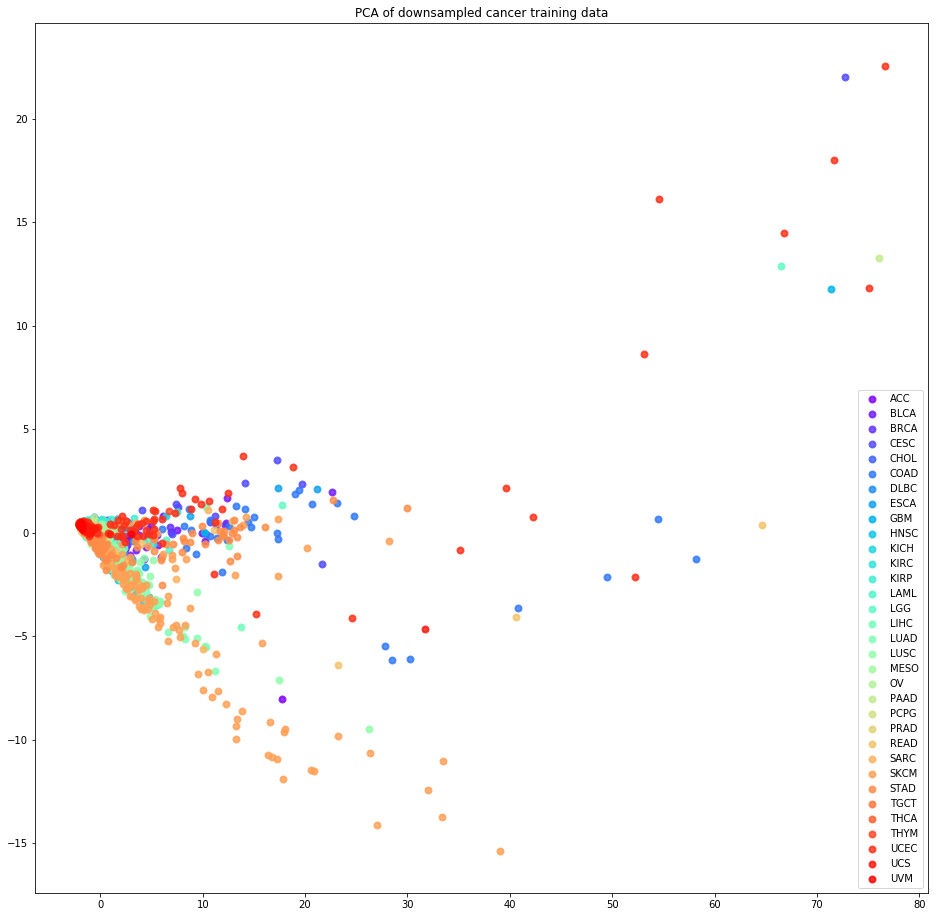

In [196]:
draw_scatterplot(new_train_data_pca, new_train_labels)

In [197]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
new_train_data_tsne = tsne.fit_transform(new_train_data)

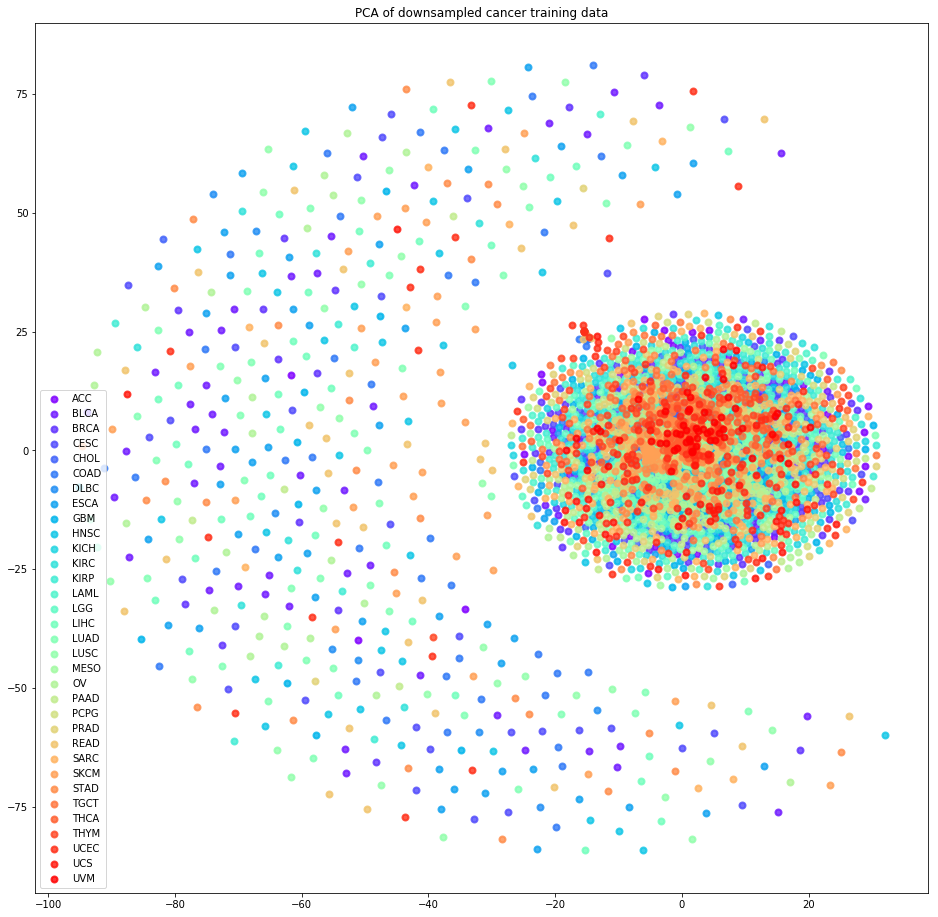

In [198]:
draw_scatterplot(new_train_data_tsne, new_train_labels)